## Objective: Assigning a customer to a certain customer category based on the total value of orders they’ve placed.

Here we have to perform customer segmentation so as to target the most valuable
customers with certain offers which promote a higher spend.

here, I’m analyzing how to segment the customers using Recency, Frequency, Monetary, and group the customers accordingly.

### RFM : Recency, Frequency, Monetary Analysis
RFM is an effective customer segmentation technique through which we can rapidly distinguish and segment customers into similar clusters and target them with separated and personalized promoting methodologies.

RFM model is based on three factors: Recency: How recently a customer has purchased a product. Frequency: How often a customer makes a purchase. Monetary Value: How much money a customer spends on purchases of products.

These three numeric values helps companies understand customer potential.

Importing required libraries

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#Mounting google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Data Extraction

In [3]:
#Data Extraction in the form of dataframe using encoding
#Encoding is used to remove UnicodeDecodeError while reading csv 
#which occurs due to different encoding, bad symbols or corrupted file
df = pd.read_csv('gdrive//My Drive//data.csv', encoding= 'unicode_escape')
df.head(6)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom


#Data Cleaning

In [4]:
#Checking shape of dataframe
df.shape

(541909, 8)

In [5]:
#Checking for missing data if any
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
#Lets drop data with no customerid
df.dropna(axis=0, subset=['CustomerID'], inplace=True)
df.shape

(406829, 8)

In [7]:
# Checking the totol number of duplicate values 
print('Duplicate values in our dataset is:',len(df[df.duplicated()]))

Duplicate values in our dataset is: 5225


In [8]:
# Dropping the duplicate values from the dataset
df.drop_duplicates(inplace = True)
print('Rows {} , Columns {}'.format(df.shape[0], df.shape[1]))

Rows 401604 , Columns 8


After dropping null and duplicate values we see that 401604 rows and 8 columns are there in this dataset.

We have to drop some Invoice No which are starts with 'C' because 'C' indicates a cancellation.

Here we creating a copy of dataframe because whatever we applying a conditions on new data so that it doesn't affect our original dataset.

In [9]:
# Creating a copy of dataframe 
data = df.copy()

In [10]:
# First converting the column as string
df['InvoiceNo'] = df['InvoiceNo'].astype('str')

In [11]:
# Lets check the InviceNo that starts with 'C'
df[df['InvoiceNo'].str.contains('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


Checking whether any line of invoice is getting repeated

In [12]:
#Removing C from  invoices column and Absolute of qty column in cancelled invoices
df['Invoice_ed'] = df['InvoiceNo'].str.replace('C','')
df['Qty_ed'] = df['Quantity'].apply(lambda x: abs(x))

In [13]:
# Checking shape of actual data
df[['StockCode', 'Description', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Invoice_ed', 'Qty_ed']].shape

(401604, 8)

In [14]:
# Checking for duplicates in the data 
# We have an assumption that the invoice line has been created and than cancelled so there should be 2 records one for order and another for cancellation
df[['StockCode', 'Description', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Invoice_ed', 'Qty_ed']].drop_duplicates().shape

(401604, 8)

**Analysis on basis of shape above**
1. If there would have been a difference between shapes than we had to remove both the rows one for order another one for cancellation
2. Since there is no difference we can directly remove all the rows with 'C' prefix

In [15]:
#We have to deal with those data of InvoiceNo which not containing 'C'
df = df[~df['InvoiceNo'].str.contains('C')]
df.drop(columns=['Invoice_ed', 'Qty_ed'], axis=1, inplace=True)
df.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(392732, 8)

#Exploratory Data Analysis (EDA)

In [16]:
#info() function from provides an overview of the data like the number of records 
#present in the data and number of columns and data type of column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392732 non-null  object 
 1   StockCode    392732 non-null  object 
 2   Description  392732 non-null  object 
 3   Quantity     392732 non-null  int64  
 4   InvoiceDate  392732 non-null  object 
 5   UnitPrice    392732 non-null  float64
 6   CustomerID   392732 non-null  float64
 7   Country      392732 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


In [17]:
# describe() function generates descriptive statistics include those
# that summarize the central tendency, dispersion, and shape of a dataset’s distributions.
df.describe()

,Quantity,UnitPrice,CustomerID
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [18]:
#Total number of unique customers
df['CustomerID'] = df['CustomerID'].astype(int)
df['CustomerID'].nunique()

4339

# PARETO ANALYSIS

In [19]:
# total price of the product is not mentioned it is separated as quantity and unit price, 
# I added a new column naming Total which contains Quantity times UnitPrice results from the total price
df['Total'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34


ON BASIS OF TRANSACTIONS

In [20]:
# Top 10 countries who are doing maximum transactions
Top_country_transaction = df['Country'].value_counts().reset_index()
Top_country_transaction.rename(columns={'index': 'Country_Name','Country': 'Count'}, inplace=True)
Top_country_transaction[:10]

,Country_Name,Count
0,United Kingdom,349227
1,Germany,9027
2,France,8327
3,EIRE,7228
4,Spain,2480
5,Netherlands,2363
6,Belgium,2031
7,Switzerland,1842
8,Portugal,1453
9,Australia,1184


Pareto Results for selecting the countries on which should do RFM analysis

In [21]:
Top_country_transaction['Per']= Top_country_transaction.Count/Top_country_transaction.Count.sum()

In [22]:
def cdf(series):
  li=[]
  for i in range(0,len(series)):
    li.append(sum(Top_country_transaction.Per[:i].astype(float)))
  return pd.Series(li).shift(-1)

In [23]:
Top_country_transaction['CDF']=cdf(Top_country_transaction['Per'])

United Kingdom itself has more than 80% of transaction

Text(0, 0.5, 'Percentage')

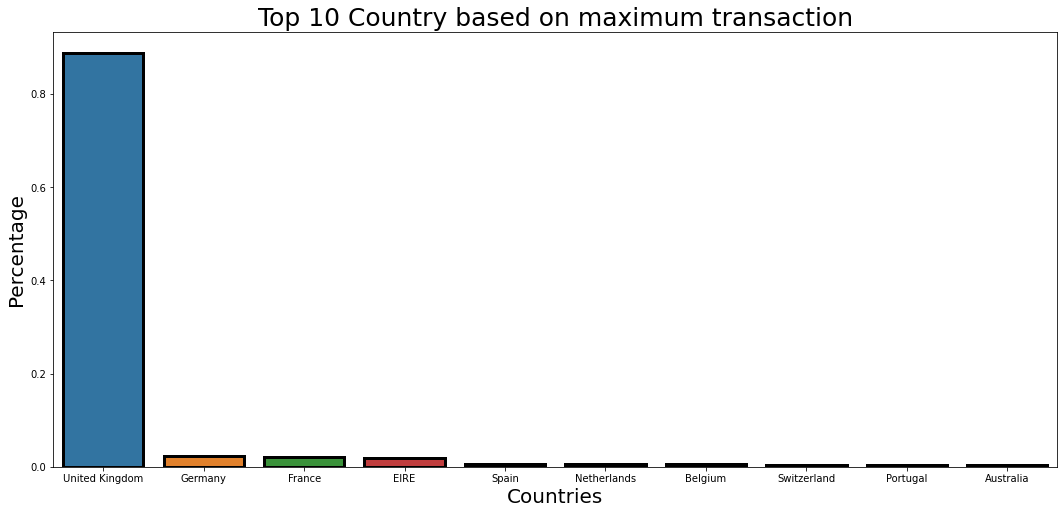

In [24]:
# Barplot of Top 10 countries who's buying maximum products
plt.figure(figsize=(18,8))
sns.barplot(x='Country_Name',y='Per',data=Top_country_transaction[:10], edgecolor = 'black',lw =3)
plt.title('Top 10 Country based on maximum transaction', SIZE = 25)
plt.xlabel('Countries', SIZE = 20)
plt.ylabel('Percentage', SIZE = 20)

From this graph we can see that most of the customers are from United Kingdom followed by Germany ,France ,EIRE and Spain, etc.

ON BASIS OF MONETORY VALUE

In [25]:
# Top 10 countries who are having maximum monetory value transaction
Top_country_monetory = df.groupby('Country')['Total'].sum().sort_values(ascending=False).reset_index()
Top_country_monetory['Per'] = Top_country_monetory['Total']/Top_country_monetory['Total'].sum()
Top_country_monetory['CDF']=cdf(Top_country_monetory['Per'])
Top_country_monetory[:10]

,Country,Total,Per,CDF
0,United Kingdom,7285024.644,0.819720,0.889225
1,Netherlands,285446.340,0.032119,0.912210
2,EIRE,265262.460,0.029848,0.933413
3,Germany,228678.400,0.025731,0.951817
4,France,208934.310,0.023510,0.958132
5,Australia,138453.810,0.015579,0.964149
6,Spain,61558.560,0.006927,0.969320
7,Switzerland,56443.950,0.006351,0.974010
8,Belgium,41196.340,0.004635,0.977710
9,Sweden,38367.830,0.004317,0.980725


United Kingdom itself has more than 80% of monetory value

Text(0, 0.5, 'Percentage')

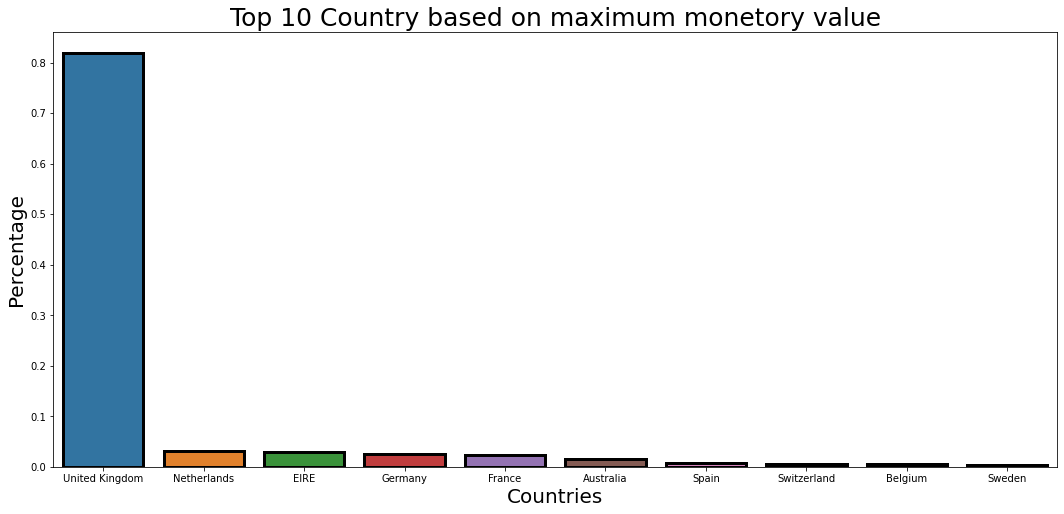

In [26]:
# Barplot of Top 10 countries who's buying maximum products
plt.figure(figsize=(18,8))
sns.barplot(x='Country',y='Per',data=Top_country_monetory[:10], edgecolor = 'black',lw =3)
plt.title('Top 10 Country based on maximum monetory value', SIZE = 25)
plt.xlabel('Countries', SIZE = 20)
plt.ylabel('Percentage', SIZE = 20)

Since both with transactional and monetory data United Kingdom drive 80% of companies economics we can proceed with it

In [27]:
# Filtering for United Kingdom
df = df[df['Country']=='United Kingdom']

In [28]:
## RFM Calculation
# Selecting date for calculation of frequency
calculating_date = max(df.InvoiceDate)
calculating_date

'9/9/2011 9:52'

In [70]:
NOW = dt.datetime(2011,12,10)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
RFM = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': 'count',
    'Total': 'sum'})

RFM['InvoiceDate'] = RFM['InvoiceDate'].astype(int)

RFM.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Total': 'MonetaryValue'}, inplace=True)
RFM.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,325,1,77183.60
12747,2,103,4196.01
12748,0,4413,33053.19
12749,3,199,4090.88
12820,3,59,942.34


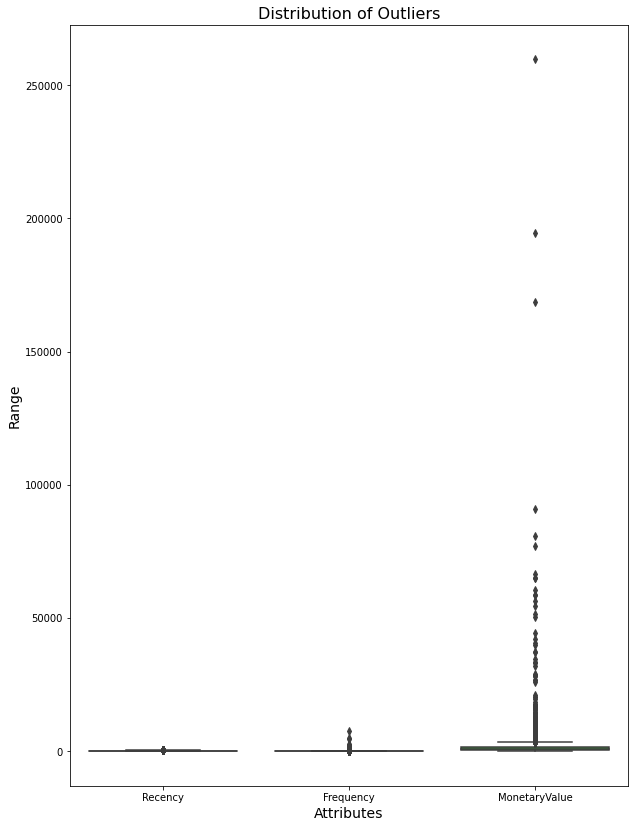

In [30]:
#Detecting Oultiers
plt.figure(figsize= (10,14))
bxplt = sns.boxplot(x="variable", y="value", data=pd.melt(RFM))
bxplt.axes.set_title("Distribution of Outliers", fontsize=16)
bxplt.set_xlabel("Attributes", fontsize=14)
bxplt.set_ylabel("Range", fontsize=14)
plt.show()

Now From the outlier distribution above we can see that, this data is suffered from outliers. So we have to remove outliers which can influence k means clustering algorithm.

We want to perform customer segmentation with the help of k-means clustering which assumes that your variables have symmetric distributions, they have same mean and same variance. So, we will prepare our data according to this assumptions.


In [31]:
# Finding the right distribution for Recency, Frequency and Monetory

In [32]:
dist_names = ['uniform', 'norm', 'lognorm', 't', 'expon',
                      'gamma', 'weibull_min', 'rayleigh']
# k-s test Null Hypothesis - 2 distributions are identical Alternate Hypothesis - 2 distributions are not identical
from scipy.stats import kstest
from scipy import stats
# Check the Distribution
def find_closest_dist(data):
  max_p_value =0
  best_dist =''
  for i in dist_names:
    try:
      s = getattr(stats, i)
      params = s.fit(data)
    except:
      params = 'Error'
      print('Distribution cannot be fitted')
    #K-s test to find closest distribution
    test_score, p_value = kstest(data, i, args=params, alternative='two-sided')
    if (p_value>max_p_value):
      max_p_value = p_value
      best_dist =i
  return max_p_value, best_dist

In [33]:
for col in RFM.columns:
  max_p_value, best_dist= find_closest_dist(RFM[col])
  print(col, best_dist, max_p_value)

Recency weibull_min 7.674933983068574e-09
Frequency lognorm 0.30432997788809274
MonetaryValue lognorm 0.0005093491492813186


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

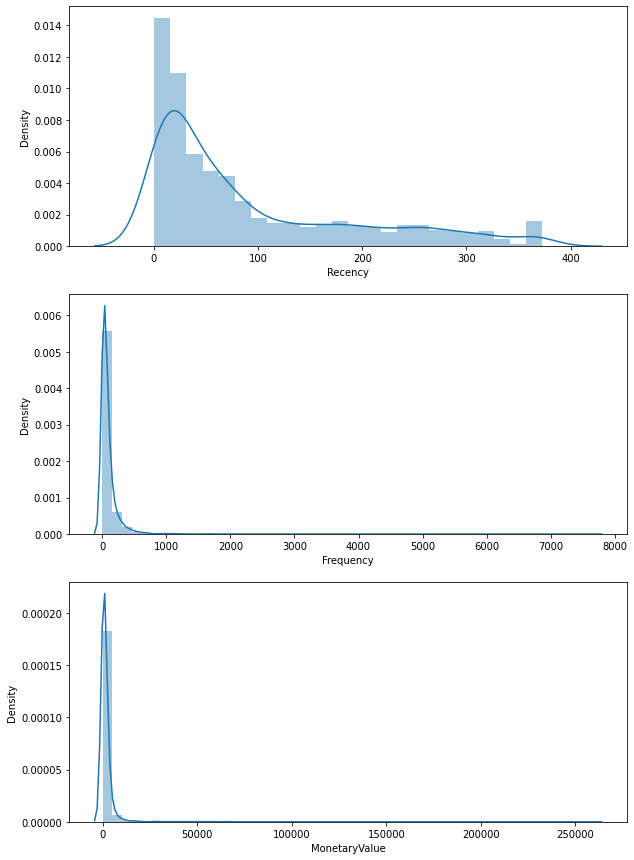

In [71]:
# Visualization of Recency, Frequency and Monetary Value
plt.figure(figsize = (10,15))
plt.subplot(3, 1, 1); sns.distplot(RFM['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM['MonetaryValue'])
plt.show()

So the data is left skewed so we need to apply log transformation. But to apply log transformation, all values should be positive. 

In [72]:
data_rfm = RFM[['Recency', 'Frequency', 'MonetaryValue']]
data_rfm.describe()

,Recency,Frequency,MonetaryValue
count,3921.000000,3921.000000,3921.000000
mean,91.722265,89.065800,1857.950687
std,99.528532,214.022733,7477.736186
min,0.000000,1.000000,0.000000
25%,17.000000,17.000000,298.110000
50%,50.000000,40.000000,644.300000
75%,142.000000,98.000000,1570.810000
max,373.000000,7676.000000,259657.300000


In [73]:
# Making all values positive of Recency, Frequency and Monetary
data_rfm_positive = data_rfm
data_rfm_positive.Recency = data_rfm.Recency + 1
data_rfm_positive.MonetaryValue = data_rfm.MonetaryValue  + 1

In [74]:
data_rfm_positive.describe()

,Recency,Frequency,MonetaryValue
count,3921.000000,3921.000000,3921.000000
mean,92.722265,89.065800,1858.950687
std,99.528532,214.022733,7477.736186
min,1.000000,1.000000,1.000000
25%,18.000000,17.000000,299.110000
50%,51.000000,40.000000,645.300000
75%,143.000000,98.000000,1571.810000
max,374.000000,7676.000000,259658.300000


In [75]:
#Applying log transformation to make the data unskewed
data_log = np.log(data_rfm_positive)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

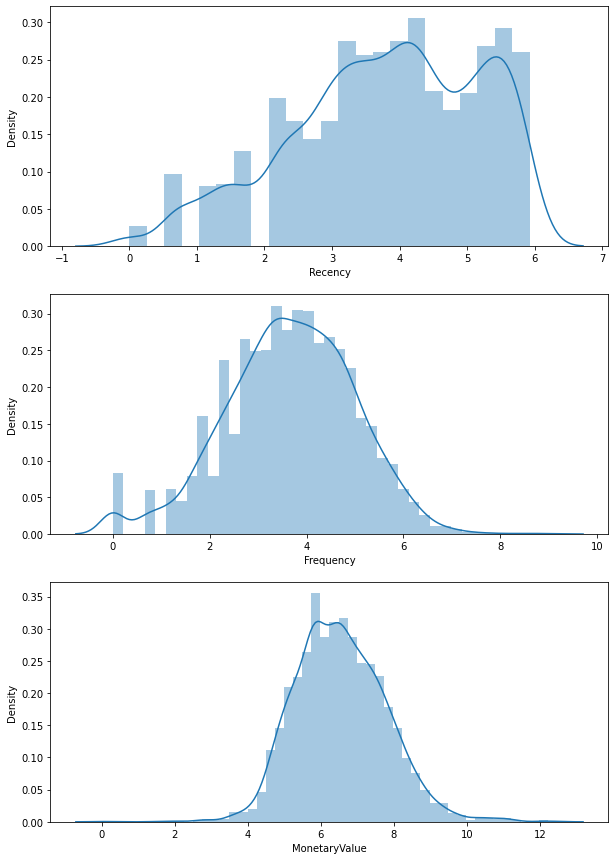

In [76]:
# Distribution of RFM after Transformation
plt.figure(figsize = (10,15))
plt.subplot(3, 1, 1); sns.distplot(data_log['Recency'])
plt.subplot(3, 1, 2); sns.distplot(data_log['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(data_log['MonetaryValue'])
plt.show()

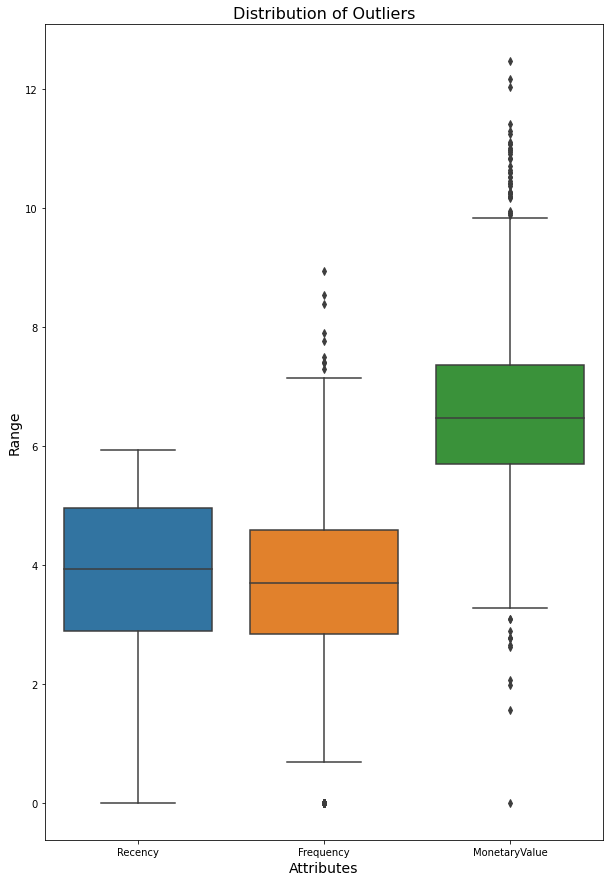

In [77]:
#Outilers Distribution after Transformation
plt.figure(figsize= (10,15))
bxplt1 = sns.boxplot(x="variable", y="value", data=pd.melt(data_log))
bxplt1.axes.set_title("Distribution of Outliers", fontsize=16)
bxplt1.set_xlabel("Attributes", fontsize=14)
bxplt1.set_ylabel("Range", fontsize=14)
plt.show()


The Distribution is almost normal but these dont have same mean and variance. so these can affect k means algorithm. Thus it is required to normalize the data. 
For this i have used standard scalar function.

Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.



In [78]:
#Standardization using Standard Scaler 
scaler = StandardScaler()
scaler.fit(data_log)
RFM_st = scaler.transform(data_log)
RFM_st = pd.DataFrame(RFM_st, index=data_rfm.index, columns=data_rfm.columns)
RFM_st

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,1.438699,-2.738860,3.776616
12747,-1.953447,0.736653,1.444286
12748,-2.748334,3.554406,3.097339
12749,-1.745299,1.230509,1.423967
12820,-1.745299,0.318823,0.248655
...,...,...,...
18280,1.323457,-1.012187,-1.071065
18281,1.012970,-1.279652,-1.709678
18282,-1.243781,-0.875466,-1.082392


In [79]:
RFM_st.describe().round(2)

,Recency,Frequency,MonetaryValue
count,3921.00,3921.00,3921.00
mean,-0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-2.75,-2.74,-5.24
25%,-0.66,-0.61,-0.67
50%,0.10,0.03,-0.06
75%,0.84,0.70,0.66
max,1.54,3.97,4.75


Now we can see that new standardized data has mean of 0 and standard deviation of 1 for all the three features.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

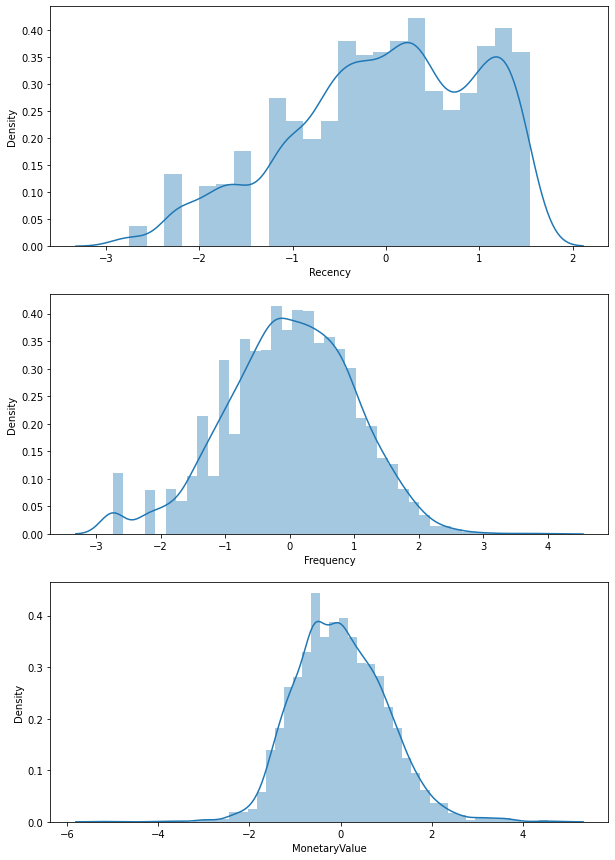

In [80]:
# Distribution of RFM after Standardization
plt.figure(figsize = (10,15))
plt.subplot(3, 1, 1); sns.distplot(RFM_st['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_st['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_st['MonetaryValue'])
plt.show()

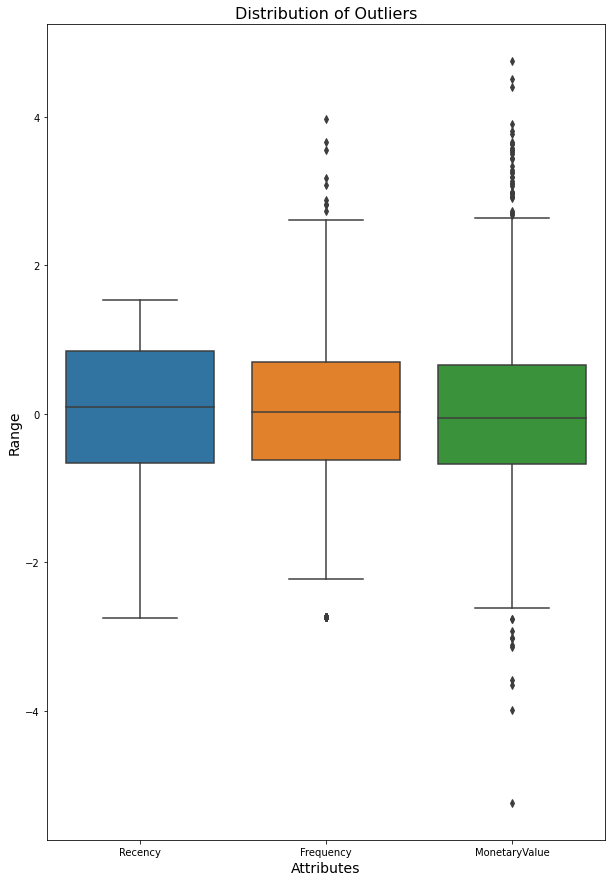

In [81]:
#Outilers Distribution after Standardization
plt.figure(figsize= (10,15))
bxplt1 = sns.boxplot(x="variable", y="value", data=pd.melt(RFM_st))
bxplt1.axes.set_title("Distribution of Outliers", fontsize=16)
bxplt1.set_xlabel("Attributes", fontsize=14)
bxplt1.set_ylabel("Range", fontsize=14)
plt.show()

Now Removing outliers from the standardized data

In [84]:
# Creating a function to remove outliers
def remove_outliers(df , column):
  '''Removes outliers in given the dataframe and column'''
  q3 = df[column].quantile(0.75)
  q1 = df[column].quantile(0.25)
  iqr = q3 - q1
  upper_limit = q3 + (1.5 * iqr)
  lower_limit = q1 - (1.5 * iqr)
  df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
  
  return df

In [85]:
# Removing the outliers using the function created
RFM_st = remove_outliers(df = RFM_st, column = 'MonetaryValue')
RFM_st = remove_outliers(df = RFM_st, column = 'Frequency')
RFM_st = remove_outliers(df = RFM_st, column = 'Recency')

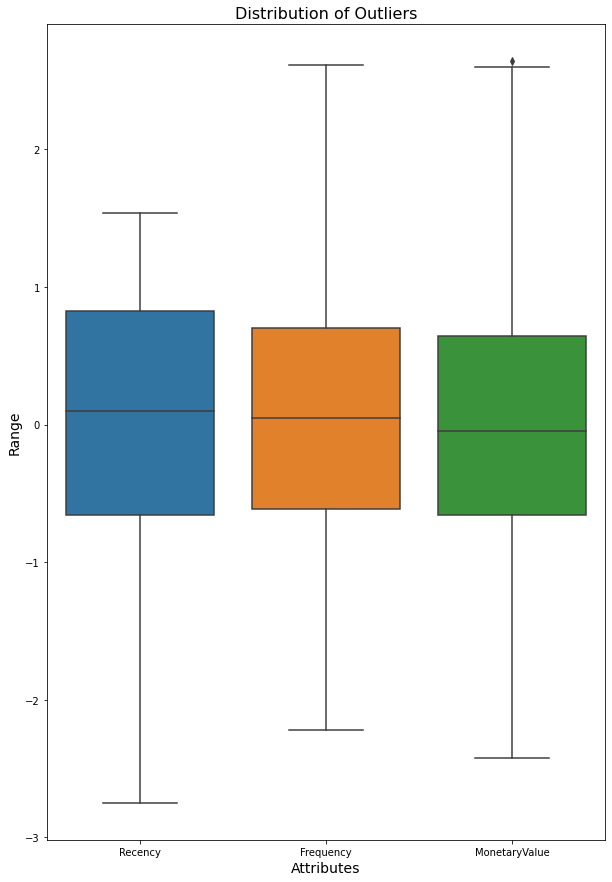

In [86]:
#Outilers Distribution after Outlier removal
plt.figure(figsize= (10,15))
bxplt1 = sns.boxplot(x="variable", y="value", data=pd.melt(RFM_st))
bxplt1.axes.set_title("Distribution of Outliers", fontsize=16)
bxplt1.set_xlabel("Attributes", fontsize=14)
bxplt1.set_ylabel("Range", fontsize=14)
plt.show()

# K-Means Clustering

Modelling- 
K-Means Clustering

Kmeans algorithm is an iterative algorithm that tries to partition the dataset into K distinct clusters. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as far as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid is at the minimum. The less variation we have within clusters, the more homogeneous the data points are within the same cluster.

I used two methods to decide K value for the K-Means clustering. one is elbow method and another is silhouette score.

### Elbow Method

In [90]:
# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(RFM_st)
    sse[k] = kmeans.inertia_ 


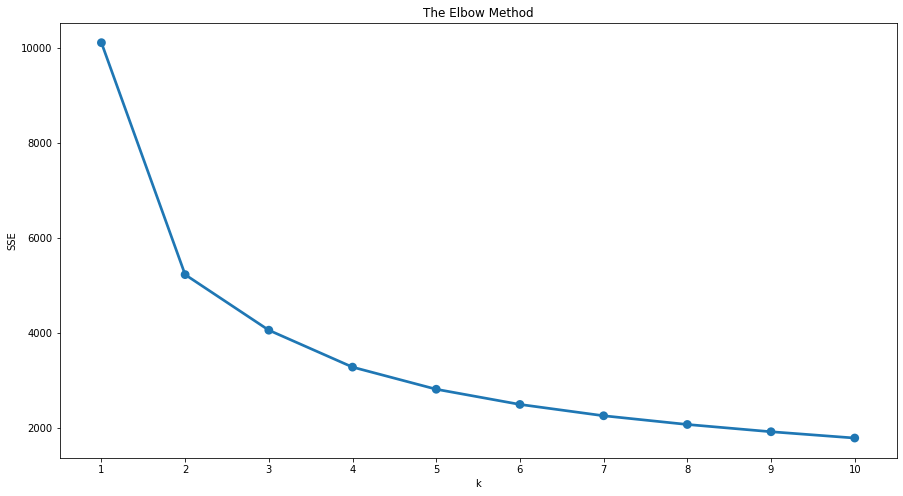

In [91]:
# Plot SSE for each *k*
plt.figure(figsize=(15,8))

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

According to Elbow method, we can see that the best value for k is 4

### Silhouette Analysis

Now we will check value of k using silhouette score and graph

In [92]:
# Creating a function to calculate silhouette scores
def sil_score(input, k):
  ''' Returns a dataframe with sillhouette scores of different clusters in the data '''
  
  sil_df = pd.DataFrame(columns = ['Clusters', 'Silhouette Score'])
  
  for i in range(2,k+1):
    kmeans = KMeans(n_clusters = i)
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    labels = kmeans.fit_predict(input)
    score = silhouette_score(input, labels)
    sil_df = sil_df.append({'Clusters' : i,
                            'Silhouette Score' : score}, ignore_index = True)
  
  return sil_df

In [93]:
# Using the function to display silhoutte scores at different number of clusters
sil_score(RFM_st,10)

,Clusters,Silhouette Score
0,2.0,0.399647
1,3.0,0.303746
2,4.0,0.311034
3,5.0,0.276861
4,6.0,0.278703
5,7.0,0.263822
6,8.0,0.258199
7,9.0,0.260487
8,10.0,0.271419


Silhoutte Graphs

In [94]:
from yellowbrick.cluster import SilhouetteVisualizer


In [95]:
def sil_graph(input, k):
    fig, ax = plt.subplots(2, 5, figsize=(15,8))
    for i in range(2, k+1):
        '''
        Create KMeans instance for different number of clusters
        '''
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
        q, mod = divmod(i, 5)
        '''
        Create SilhouetteVisualizer instance with KMeans instance
        Fit the visualizer
        '''
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(input) 

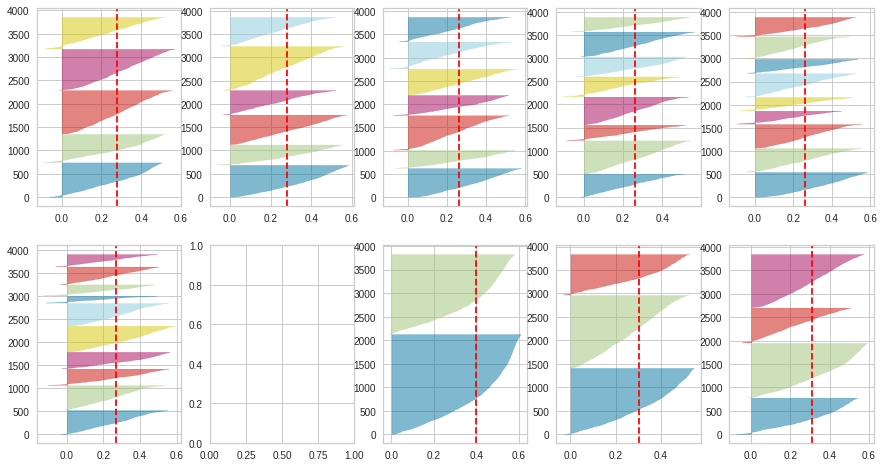

In [96]:
sil_graph(RFM_st,10)

From silhoutte score and silhoutte graph we understand best no of clusters are either 3 or 4 since score reduction is minimum with increase in cluster and negative values are minimal as found from silhoutte graph

As both methods suggest value of k as 4. Thus we have used no. of clusters as 4

In [104]:
data_new = RFM.copy()
data_new = data_new.filter(items = list(RFM_st.index), axis=0)
# KMeans with 3 clusters
kmeans = KMeans(n_clusters = 4, random_state=10)

# Fitting the model to the data
kmeans.fit(RFM_st)

# Creating cluster labels for the data and appending it to the RFM dataframe
labels = kmeans.predict(RFM_st)
data_new['Cluster'] = labels

# First 5 rows of the RFM dataframe after adding the cluster column
data_new.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12747,2,103,4196.01,1
12749,3,199,4090.88,1
12820,3,59,942.34,1
12821,214,6,92.72,3
12822,70,46,948.88,2


In [105]:
data_new.Cluster.value_counts()

3    1157
2    1133
1     776
0     743
Name: Cluster, dtype: int64

In [106]:
#Cluster Profiling
# Grouping by clusters to understand the profiles
data_new.groupby('Cluster').mean()

,Recency,Frequency,MonetaryValue
Cluster,,,
0,24.246299,29.234186,446.678910
1,10.448454,223.378866,3683.857874
2,81.504854,85.268314,1401.406437
3,195.571305,17.050130,309.513657


In [113]:
# Labeling Clusters
#Cluster 0 ----> low spenders, less Frequent buyers, recently bought ----> Low Value Customers
#Cluster 1-----> High value, high freq,  - Big Spenders
#Cluster 2-----> High Recency, less frequent, high monetory value-----> High Value almost lost 
#Cluster 3-----> High Recency, less frequent, Low Monetory Value------>Lost Cheap Customers
label_dict = {0:'Low Value Customers', 1:'Big Spenders', 2:'High Value almost lost', 3:'Lost Cheap Customers'}
data_new['label']= data_new['Cluster'].map(label_dict)
data_new

,CustomerID,Recency,Frequency,MonetaryValue,Cluster,label
0,12747,2,103,4196.01,1,Big Spenders
1,12749,3,199,4090.88,1,Big Spenders
2,12820,3,59,942.34,1,Big Spenders
3,12821,214,6,92.72,3,Lost Cheap Customers
4,12822,70,46,948.88,2,High Value almost lost
...,...,...,...,...,...,...
3804,18280,277,10,180.60,3,Lost Cheap Customers
3805,18281,180,7,80.82,3,Lost Cheap Customers
3806,18282,7,12,178.05,0,Low Value Customers
3807,18283,3,721,2045.53,1,Big Spenders


In [114]:
data_new = data_new.reset_index()

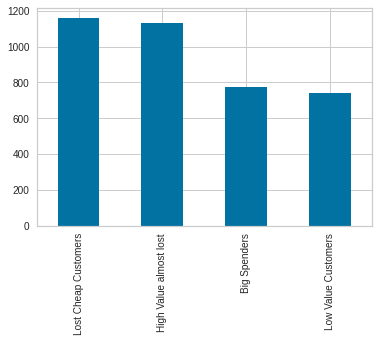

In [115]:
# Bar plots to visualize customer segmentation
data_new.label.value_counts().plot(kind='bar')